## DNN - By Hugo

IMPORT SIDE

In [1]:
import os
import torch
import torch.nn as nn
from torch.nn.modules.activation import Threshold
from sklearn.datasets import make_circles
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tqdm as notebook_tqdm

DEVICE SIDE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DNN SIDE

In [3]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.archiNN = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.archiNN(x)
    
dnn = DNN(2, 32, 1).to(device)

DATASET SIDE

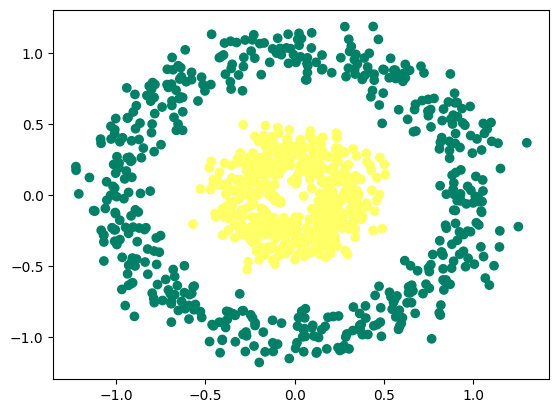

In [4]:
X_train, y_train = make_circles(n_samples=1000, noise=0.1, factor=0.3, random_state=0)
X_train = X_train.T
y_train = y_train.reshape((1, y_train.shape[0]))

# SHOW MY DATASET
plt.scatter(X_train[0, :], X_train[1, :], c=y_train, cmap='summer')
plt.show()

In [5]:
batch_size = 32

inputs_tensor = torch.tensor(X_train.T, dtype=torch.float32).to(device)
outputs_tensor = torch.tensor(y_train.T, dtype=torch.float32).to(device)

trainset = TensorDataset(inputs_tensor, outputs_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(dnn.parameters(), lr=0.001)

TRAINSIDE

In [6]:
def train(dataloader, model, loss_fn, optimizer, num_epoch):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    accuracies = []

    for epoch in notebook_tqdm.tqdm(range(num_epoch)):
        epoch_loss = 0.0

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accuracies.append(accuracy_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy().round()))

        losses.append(epoch_loss)

    fig, axs = plt.subplots(2)
    fig.suptitle('Loss and Accuracy')
    axs[0].plot(losses)
    axs[0].set_ylabel('Loss')
    axs[1].plot(accuracies)
    axs[1].set_ylabel('Accuracy')
    plt.show()

100%|██████████| 500/500 [00:18<00:00, 26.42it/s]


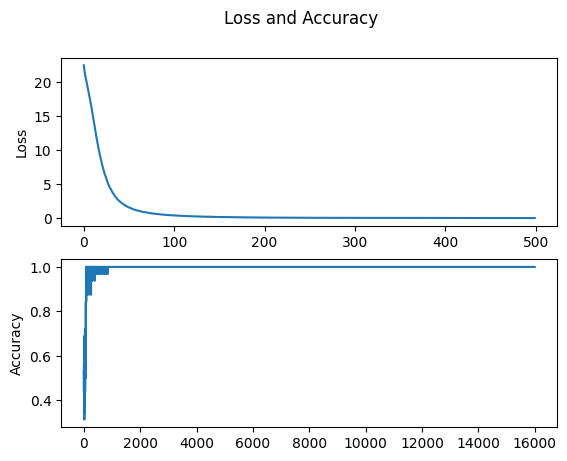

In [7]:
train(trainloader, dnn, loss_fn, optimizer, 500)

In [8]:
test_inputs, test_labels = make_circles(n_samples=10, noise=0.1, factor=0.3, random_state=1)

test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).to(device)

print(test_labels_tensor)

with torch.no_grad():
    predictions = dnn(test_inputs_tensor)

binary_predictions = (predictions.cpu().detach().numpy() > 0.5).astype(int)

print("Binary predictions:", binary_predictions.T)

tensor([0., 1., 1., 0., 0., 0., 0., 1., 1., 1.])
Binary predictions: [[0 1 1 0 0 0 0 1 1 1]]
